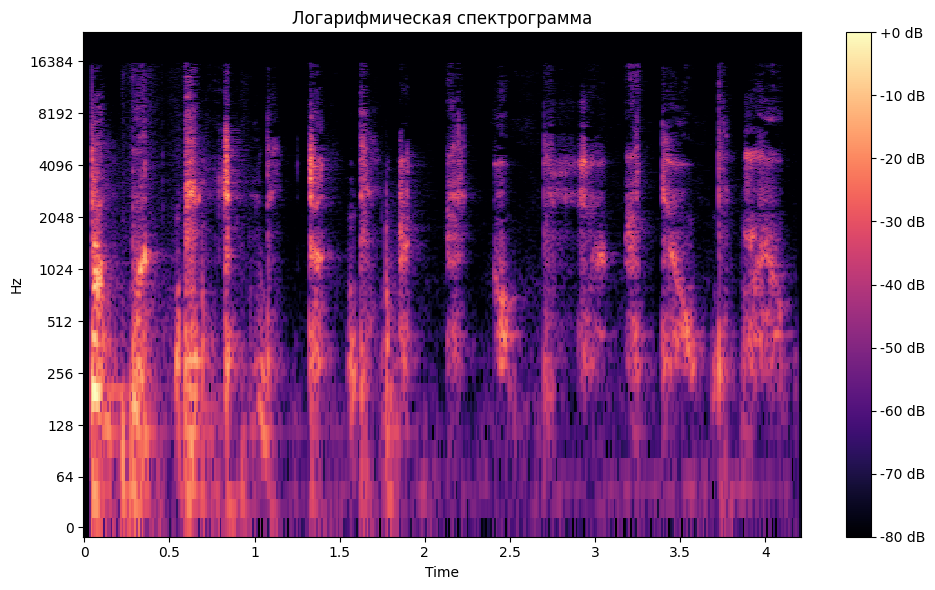

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import librosa
import librosa.display

# Загрузка аудио
y, sr = librosa.load("./bit.wav", sr=None, mono=True)

# Применение STFT с окном Ханна
n_fft = 2048
hop_length = 512
S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Построение спектрограммы
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Логарифмическая спектрограмма')
plt.tight_layout()
plt.savefig("spectrogram.png")
plt.show()

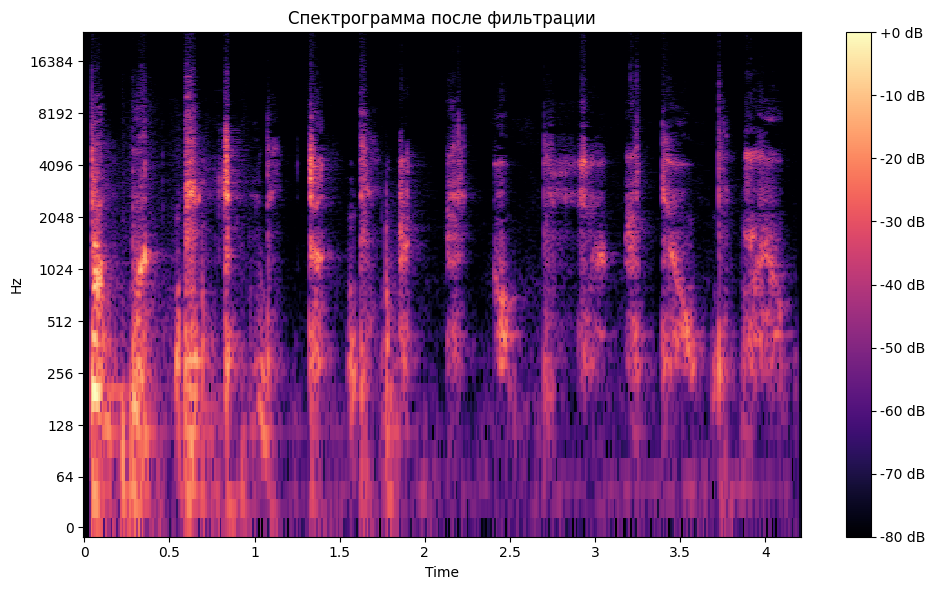

In [20]:
from scipy.signal import wiener

# Применим фильтр Винера
denoised = wiener(y)

# Спектрограмма после фильтрации
S_denoised = librosa.stft(denoised, n_fft=n_fft, hop_length=hop_length, window='hann')
S_denoised_db = librosa.amplitude_to_db(np.abs(S_denoised), ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(S_denoised_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Спектрограмма после фильтрации')
plt.tight_layout()
plt.savefig("spectrogram_denoised.png")
plt.show()


In [21]:
frame_length = int(sr * 0.1)  # 0.1 секунда
hop_length = frame_length // 2

# Энергия сигнала в каждом окне
energy = np.array([
    np.sum(y[i:i + frame_length] ** 2)
    for i in range(0, len(y) - frame_length, hop_length)
])

max_energy_index = np.argmax(energy)
max_time = max_energy_index * hop_length / sr

print(f"Максимальная энергия около {max_time:.2f} сек.")

# Альтернатива — в частотной области с ограничением по частоте:
frequencies, times, Sxx = signal.spectrogram(y, sr, nperseg=frame_length, noverlap=hop_length)
energy_band = np.sum(Sxx[(frequencies >= 40) & (frequencies <= 90), :], axis=0)
peak_time_index = np.argmax(energy_band)
peak_time = times[peak_time_index]
print(f"Пиковая энергия в диапазоне 40–90 Гц: {peak_time:.2f} сек.")


Максимальная энергия около 0.00 сек.
Пиковая энергия в диапазоне 40–90 Гц: 0.25 сек.


In [22]:
from scipy.signal import savgol_filter
y_savgol = savgol_filter(y, window_length=101, polyorder=3)

In [23]:
from scipy.signal import butter, filtfilt

# Порог фильтрации
cutoff = 2000  # Гц
order = 6

# Нормализованная частота
nyquist = 0.5 * sr
normal_cutoff = cutoff / nyquist

# Создание фильтра
b, a = butter(order, normal_cutoff, btype='low', analog=False)
y_lowpass = filtfilt(b, a, y)

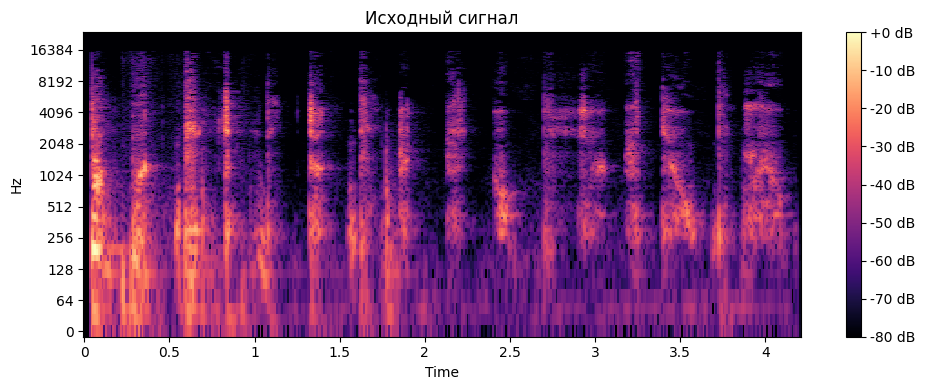

In [24]:
def plot_spec(signal, title, filename):
    S = librosa.stft(signal, n_fft=2048, hop_length=512, window='hann')
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_spec(y, "Исходный сигнал", "original.png")


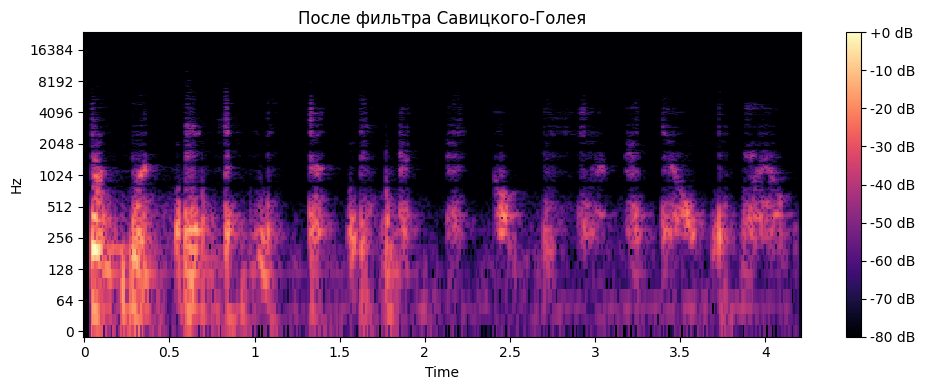

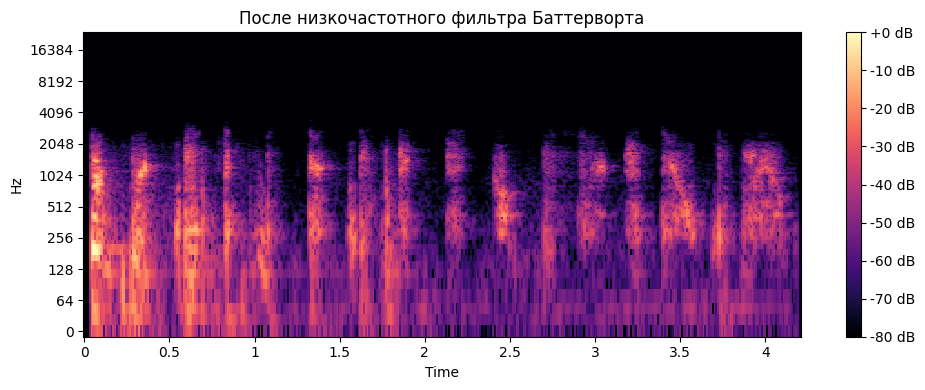

In [25]:
plot_spec(y_savgol, "После фильтра Савицкого-Голея", "savgol.png")
plot_spec(y_lowpass, "После низкочастотного фильтра Баттерворта", "butter_lowpass.png")

In [26]:
import soundfile as sf

sf.write("savgol_filtered.wav", y_savgol, sr)
sf.write("butter_lowpass_filtered.wav", y_lowpass, sr)